In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from joblib import Memory
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from numpy import arange
import time
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
import re
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error
import scipy.stats as st
import math
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from shutil import rmtree

# Data load and preparation

## Load

In [3]:
# load the dataset
data = pd.read_csv('2015_2016_building_energy_benchmarking.csv', sep=',',
                   decimal='.', encoding='utf8', low_memory=False)

# print dataset details
print('Dataset: ' + str(data.shape))
print('')
print('Colonnes')
print('---------------------------------------------------------')
print(data.columns)
print('')
print('Valeurs manquantes')
print('---------------------------------------------------------')
print(data.isnull().any())
print('')

Dataset: (1573, 19)

Colonnes
---------------------------------------------------------
Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Usage_nb', 'SteamUsed',
       'ElectricityUsed', 'NaturalGasUsed'],
      dtype='object')

Valeurs manquantes
---------------------------------------------------------
BuildingType                       False
PrimaryPropertyType                False
Neighborhood                       False
YearBuilt                          False
NumberofFloors                     False
PropertyGFATotal                   False
PropertyGFAParking                 False
PropertyGFABuilding(s)             False
LargestPropertyUseType         

## Split

In [5]:
print('Split Dataset')
print('---------------------------------------------------------')
X_train, X_test = train_test_split(data, random_state=0, test_size=0.2)
print('X_train: ' + str(X_train.shape))
print('X_test: ' + str(X_test.shape))

Split Dataset
---------------------------------------------------------
X_train: (1258, 19)
X_test: (315, 19)


In [6]:
X_train_last = X_train.loc[:, (X_train.columns != 'SiteEnergyUse(kBtu)') &
                              (X_train.columns != 'TotalGHGEmissions') &
                              (X_train.columns != 'ENERGYSTARScore')
                           ]
X_test_last = X_test.loc[:, (X_test.columns != 'SiteEnergyUse(kBtu)') &
                            (X_test.columns != 'TotalGHGEmissions') &
                            (X_train.columns != 'ENERGYSTARScore')]
print('X_train_last: ' + str(X_train_last.shape))
print('X_test_last: ' + str(X_test_last.shape))

X_train_last: (1258, 16)
X_test_last: (315, 16)


In [7]:
y_train_conso = X_train['SiteEnergyUse(kBtu)']
y_test_conso = X_test['SiteEnergyUse(kBtu)']
y_train_co2 = X_train['TotalGHGEmissions']
y_test_co2 = X_test['TotalGHGEmissions']
print('y_train_conso: ' + str(y_train_conso.shape))
print('y_test_conso: ' + str(y_test_conso.shape))
print('y_train_co2: ' + str(y_train_co2.shape))
print('y_test_co2: ' + str(y_test_co2.shape))

y_train_conso: (1258,)
y_test_conso: (315,)
y_train_co2: (1258,)
y_test_co2: (315,)


# Preprocessing

In [9]:
# https://scikit-learn.org/stable/modules/compose.html
location = 'C:\\Users\\james\\__p3cache__'
cachedir = Memory(location, verbose=0)

## Imputer

In [11]:
imputer = IterativeImputer(initial_strategy='mean', max_iter=10)

## Encoder

In [13]:
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

## Transformer

In [15]:
scaler = StandardScaler(with_mean=False, with_std=False)

## Preprocessor

In [17]:
categoricals = list(X_train_last.select_dtypes('object').columns)
numericals = list(X_train_last.select_dtypes(exclude='object').columns)

In [18]:
pipe_num = Pipeline(steps=[('imputer', imputer),
                    ('scaler', scaler)], memory=cachedir)

In [19]:
pipe_cat = Pipeline(steps=[('ohe', ohe)], memory=cachedir)

In [20]:
preprocessor = ColumnTransformer(transformers=[('num', pipe_num, numericals),
                                               ('cat', pipe_cat, categoricals)
                                               ], remainder='passthrough')

# Modelization

## Models

In [22]:
# Linear regression with L1 and L2 combined as regularizers.
en = ElasticNet()

In [23]:
# Ensemble models

# Parallel
rfr = RandomForestRegressor()
# Sequential
hgbr = HistGradientBoostingRegressor()

In [24]:
model_list = list()
model_list.append(('ElasticNet', en))
model_list.append(('RandomForestRegressor', rfr))
model_list.append(('HistGradientBoostingRegressor', hgbr))

## Pipelines

In [25]:
def get_pipelines():
    pipelines = list()

    for model_name, model in model_list:
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)])
        pipelines.append((model_name, pipe))

    return pipelines

## Hyperparameters

In [27]:
def get_params(model_name):

    # Liste et valeurs des hyperparamètres à tester pour chaque combinaison modèle / transformer

    if 'ElasticNet' in model_name:
        params = [{'preprocessor__num__scaler': [StandardScaler()],
                   'preprocessor__num__scaler__with_mean': [False, True],
                   'preprocessor__num__scaler__with_std': [False, True],
                   'model__alpha': [50, 100],
                   'model__l1_ratio': [0.50, 1],
                   'model__max_iter': [3000],
                   'model__tol': [1e-3],
                   'model__selection': ['cyclic', 'random']},
                  {'preprocessor__num__scaler': [Normalizer()],
                   'preprocessor__num__scaler__norm': ['l1', 'l2', 'max'],
                   'model__alpha': [50, 100],
                   'model__l1_ratio': [0.50, 1],
                   'model__max_iter': [3000],
                   'model__tol': [1e-3],
                   'model__selection': ['cyclic', 'random']},
                  {'preprocessor__num__scaler': [QuantileTransformer()],
                   'preprocessor__num__scaler__n_quantiles': [10, 100, 1000],
                   'model__alpha': [50, 100],
                   'model__l1_ratio': [0.50, 1],
                   'model__max_iter': [3000],
                   'model__tol': [1e-3],
                   'model__selection': ['cyclic', 'random']}
                  ]

    elif 'RandomForestRegressor' in model_name:
        params = [{'preprocessor__num__scaler': [StandardScaler()],
                   'preprocessor__num__scaler__with_mean': [False, True],
                   'preprocessor__num__scaler__with_std': [False, True],
                   'model__n_estimators': [100],
                   'model__max_depth': [25, 100],  # [25, 50, 75, 100]
                   'model__min_samples_split': [25, 50],  # [2, 25, 75, 100]
                   'model__max_features': [4, 8, 'auto', 'sqrt', 'log2']},
                  {'preprocessor__num__scaler': [Normalizer()],
                   'preprocessor__num__scaler__norm': ['l1', 'l2', 'max'],
                   'model__n_estimators': [100],
                   'model__max_depth': [25, 100],
                   'model__min_samples_split': [25, 50],
                   'model__max_features': [4, 8, 'auto', 'sqrt', 'log2']},
                  {'preprocessor__num__scaler': [QuantileTransformer()],
                   'preprocessor__num__scaler__n_quantiles': [10, 100, 1000],
                   'model__n_estimators': [100],
                   'model__max_depth': [25, 100],
                   'model__min_samples_split': [25, 50],
                   'model__max_features': [4, 8, 'auto', 'sqrt', 'log2']}
                  ]

    elif 'HistGradientBoostingRegressor' in model_name:
        params = [{'preprocessor__num__scaler': [StandardScaler()],
                   'preprocessor__num__scaler__with_mean': [False, True],
                   'preprocessor__num__scaler__with_std': [False, True],
                   'model__loss': ['squared_error', 'absolute_error', 'poisson'],
                   'model__learning_rate': [0, 0.50, 1],
                   'model__max_iter': [100],
                   'model__min_samples_leaf': [2, 10, 20],
                   'model__max_bins': [2, 127, 255],
                   'model__early_stopping': [True]},
                  {'preprocessor__num__scaler': [Normalizer()],
                   'preprocessor__num__scaler__norm': ['l1', 'l2', 'max'],
                   'model__loss': ['squared_error', 'absolute_error', 'poisson'],
                   'model__learning_rate': [0, 0.50, 1],
                   'model__max_iter': [100],
                   'model__min_samples_leaf': [2, 10, 20],
                   'model__max_bins': [2, 127, 255],
                   'model__early_stopping': [True]},
                  {'preprocessor__num__scaler': [QuantileTransformer()],
                   'preprocessor__num__scaler__n_quantiles': [10, 100, 1000],
                   'model__loss': ['squared_error', 'absolute_error', 'poisson'],
                   'model__learning_rate': [0, 0.50, 1],
                   'model__max_iter': [100],
                   'model__min_samples_leaf': [2, 10, 20],
                   'model__max_bins': [2, 127, 255],
                   'model__early_stopping': [True]}
                  ]

    return params

## Evaluation

In [29]:
def evaluation(y, display):

    fit_times = ()
    score_times = ()
    scores_train = ()
    scores_test = ()
    grids = dict()

    for name, pipeline in get_pipelines():
        print('-------------------------------------------------------')
        print(name)
        print('-------------------------------------------------------')
        print('Start: ', time.asctime())

        grid = GridSearchCV(pipeline,
                            param_grid=get_params(name),
                            scoring='r2',
                            verbose=1,
                            cv=5,
                            n_jobs=-1,
                            return_train_score=True,
                            refit=True)

        regr_trans = TransformedTargetRegressor(
            regressor=grid, func=None, inverse_func=None)
        regr_trans.fit(X_train_last, y)

        if display:
            print('Meilleur(s) hyperparamètre(s) sur le testing set')
            print(regr_trans.regressor_.best_params_)
            print('')

        mean_fit_time = regr_trans.regressor_.cv_results_[
            'mean_fit_time'][regr_trans.regressor_.best_index_]
        fit_times = fit_times + (mean_fit_time,)
        if display:
            print('mean_fit_time: ' + str(mean_fit_time))

        mean_score_time = regr_trans.regressor_.cv_results_[
            'mean_score_time'][regr_trans.regressor_.best_index_]
        score_times = score_times + (mean_score_time,)
        if display:
            print('mean_score_time: ' + str(mean_score_time))

        mean_train_score = regr_trans.regressor_.cv_results_[
            'mean_train_score'][regr_trans.regressor_.best_index_]
        scores_train = scores_train + (mean_train_score,)
        if display:
            print('mean_train_score: ' + str(mean_train_score))

        mean_test_score = regr_trans.regressor_.cv_results_[
            'mean_test_score'][regr_trans.regressor_.best_index_]
        scores_test = scores_test + (mean_test_score,)
        if display:
            print('mean_test_score: ' + str(mean_test_score))

        grids[name] = regr_trans

        print('End: ', time.asctime())
        print('')

    return fit_times, score_times, scores_train, scores_test, grids

In [30]:
def final(regressor, X_test, y_test, model_name, title, tabrmse, tabr2):
    y_pred = regressor.predict(X_test)

    # Graph
    plt.scatter(y_test, y_pred, label=model_name)
    plt.ylabel("Target predicted")
    plt.xlabel("True Target")
    plt.title(title)
    plt.xlim([0, y_test.max()])
    plt.ylim([0, y_pred.max()])
    plt.show()

    # Coefs
    print('')
    print('MSE (Mean Squared Error)=%.3f' % mean_squared_error(y_test, y_pred))
    print('RMSE (Root Mean Squared Error)=%.3f' %
          math.sqrt(mean_squared_error(y_test, y_pred)))
    tabrmse = tabrmse + (math.sqrt(mean_squared_error(y_test, y_pred)),)
    print('')
    print("R2 Test set=%.2f" % r2_score(y_test, y_pred))
    tabr2 = tabr2 + (r2_score(y_test, y_pred),)
    print("RSE (Relative Squared Error)=%.2f" % (1-r2_score(y_test, y_pred)))
    print('')
    stat, p = st.pearsonr(y_test, y_pred)
    print('Pearson=%.3f, pvalue=%.3f' % (stat, p))

    return tabrmse, tabr2

## Graphique

In [32]:
models = []

for model_name, model in model_list:
    models.append(re.sub('[^A-Z]', '', model_name))

In [33]:
def graphFitScore(model_list, data1, data2, ylabel, title, label1, label2):
    N = len(model_list)

    ind = np.arange(N)
    width = 0.35
    plt.bar(ind, data1, width, label=label1)
    plt.bar(ind + width, data2, width, label=label2)

    plt.ylabel(ylabel)
    plt.title(title)

    plt.xticks(ind + width / 2, models)
    plt.legend(loc='best')
    plt.gcf().savefig(title, dpi=100)
    plt.show()

In [34]:
def graph(model_list, train, test, ylabel, title):
    N = len(model_list)

    ind = np.arange(N)
    width = 0.35
    plt.bar(ind, train, width, label='train')
    plt.bar(ind + width, test, width, label='test')

    plt.ylabel(ylabel)
    plt.title(title)

    plt.xticks(ind + width / 2, models)
    plt.legend(loc='best')
    plt.gcf().savefig(title, dpi=100)
    plt.show()

# Evaluation of models by cross-validation

In [35]:
rmse_conso = ()
r2conso = ()
rmse_co2 = ()
r2co2 = ()

## Energy consumption

In [36]:
fit_times_conso, score_times_conso, scores_train_conso, scores_test_conso, grids_conso = evaluation(
    y_train_conso, True)

-------------------------------------------------------
ElasticNet
-------------------------------------------------------
Start:  Fri Dec 24 17:03:02 2021
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Meilleur(s) hyperparamètre(s) sur le testing set
{'model__alpha': 100, 'model__l1_ratio': 0.5, 'model__max_iter': 3000, 'model__selection': 'cyclic', 'model__tol': 0.001, 'preprocessor__num__scaler': StandardScaler(with_std=False), 'preprocessor__num__scaler__with_mean': True, 'preprocessor__num__scaler__with_std': False}

mean_fit_time: 0.5321223735809326
mean_score_time: 0.014003562927246093
mean_train_score: 0.7790261350106583
mean_test_score: 0.538710448119629
End:  Fri Dec 24 17:03:14 2021

-------------------------------------------------------
RandomForestRegressor
-------------------------------------------------------
Start:  Fri Dec 24 17:03:14 2021
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Meilleur(s) hyperparamètre(s) sur le testing set
{

In [37]:
r2conso = r2conso + (scores_test_conso[1],)

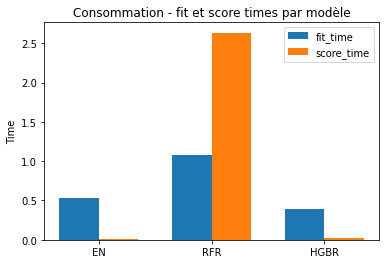

In [38]:
# Graph
graphFitScore(model_list, fit_times_conso, score_times_conso, 'Time',
              'Consommation - fit et score times par modèle', 'fit_time', 'score_time')

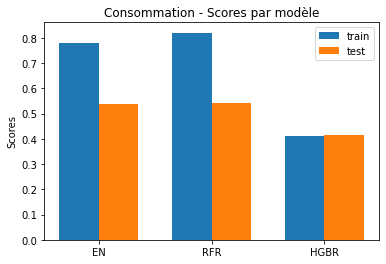

In [39]:
graph(model_list, scores_train_conso, scores_test_conso,
      'Scores', 'Consommation - Scores par modèle')

## CO2 emissions

In [40]:
fit_times_co2, score_times_co2, scores_train_co2, scores_test_co2, grids_co2 = evaluation(
    y_train_co2, True)

-------------------------------------------------------
ElasticNet
-------------------------------------------------------
Start:  Fri Dec 24 17:04:54 2021
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Meilleur(s) hyperparamètre(s) sur le testing set
{'model__alpha': 100, 'model__l1_ratio': 1, 'model__max_iter': 3000, 'model__selection': 'cyclic', 'model__tol': 0.001, 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__num__scaler__with_mean': True, 'preprocessor__num__scaler__with_std': True}

mean_fit_time: 0.06001729965209961
mean_score_time: 0.016803503036499023
mean_train_score: 0.4507455635197136
mean_test_score: 0.15985068577202827
End:  Fri Dec 24 17:04:58 2021

-------------------------------------------------------
RandomForestRegressor
-------------------------------------------------------
Start:  Fri Dec 24 17:04:58 2021
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Meilleur(s) hyperparamètre(s) sur le testing set
{'model__max_de

In [41]:
r2co2 = r2co2 + (scores_test_co2[1],)

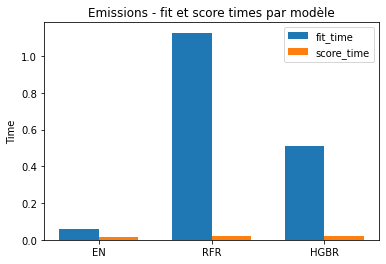

In [42]:
# Graph
graphFitScore(model_list, fit_times_co2, score_times_co2, 'Time', 'Emissions - fit et score times par modèle',
              'fit_time', 'score_time')

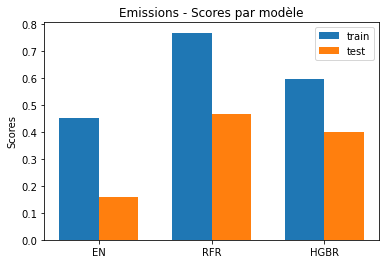

In [43]:
graph(model_list, scores_train_co2, scores_test_co2,
      'Scores', 'Emissions - Scores par modèle')

# Final models evaluation

## Energy consumption

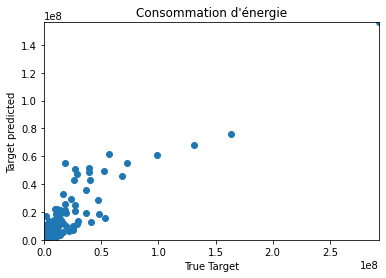


MSE (Mean Squared Error)=138953974253004.344
RMSE (Root Mean Squared Error)=11787874.034

R2 Test set=0.74
RSE (Relative Squared Error)=0.26

Pearson=0.900, pvalue=0.000


In [45]:
rmse_conso, r2conso = final(grids_conso['RandomForestRegressor'], X_test_last, y_test_conso,
                            'RandomForestRegressor', "Consommation d'énergie", rmse_conso, r2conso)

## CO2 emissions

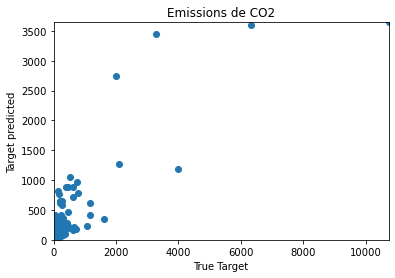


MSE (Mean Squared Error)=236804.725
RMSE (Root Mean Squared Error)=486.626

R2 Test set=0.61
RSE (Relative Squared Error)=0.39

Pearson=0.847, pvalue=0.000


In [46]:
rmse_co2, r2co2 = final(grids_co2['RandomForestRegressor'], X_test_last, y_test_co2,
                        'RandomForestRegressor', 'Emissions de CO2', rmse_co2, r2co2)

# Tuning

## Energy consumption

### StandardScaler on target

In [55]:
standards_pipe_conso = clone(grids_conso['RandomForestRegressor'])

In [56]:
standards_pipe_conso.transformer = StandardScaler()

In [63]:
print('Start: ', time.asctime())
standards_conso = standards_pipe_conso.fit(X_train_last, y_train_conso)
print('End: ', time.asctime())

Start:  Fri Dec 24 17:10:07 2021
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
End:  Fri Dec 24 17:10:36 2021


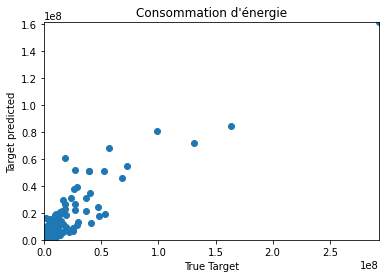


MSE (Mean Squared Error)=125887520883204.828
RMSE (Root Mean Squared Error)=11219960.824

R2 Test set=0.76
RSE (Relative Squared Error)=0.24

Pearson=0.909, pvalue=0.000


In [64]:
rmse_conso, r2conso = final(standards_pipe_conso, X_test_last, y_test_conso,
                            'RandomForestRegressor', "Consommation d'énergie", rmse_conso, r2conso)

### Hyperparameters

In [65]:
standards_pipe_conso.regressor_.best_params_

{'model__max_depth': 100,
 'model__max_features': 'auto',
 'model__min_samples_split': 25,
 'model__n_estimators': 100,
 'preprocessor__num__scaler': QuantileTransformer(),
 'preprocessor__num__scaler__n_quantiles': 1000}

In [66]:
standards_pipe_conso.regressor.param_grid = {
    'model__max_depth': arange(50, 75, 1),
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__min_samples_split': arange(2, 25, 5),
    'model__n_estimators': arange(80, 120, 5),
    'preprocessor__num__scaler': [QuantileTransformer()],
    'preprocessor__num__scaler__n_quantiles': [1000]}

In [67]:
print('Start: ', time.asctime())
fit = standards_pipe_conso.fit(X_train_last, y_train_conso)
print('End: ', time.asctime())

Start:  Fri Dec 24 17:11:38 2021
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
End:  Fri Dec 24 17:22:20 2021


In [68]:
standards_pipe_conso.regressor_.best_params_

{'model__max_depth': 50,
 'model__max_features': 'auto',
 'model__min_samples_split': 7,
 'model__n_estimators': 85,
 'preprocessor__num__scaler': QuantileTransformer(),
 'preprocessor__num__scaler__n_quantiles': 1000}

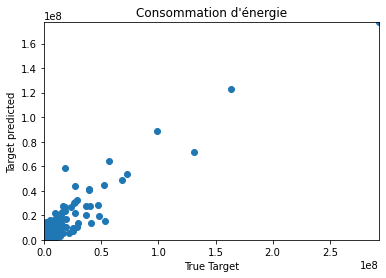


MSE (Mean Squared Error)=95006955497952.578
RMSE (Root Mean Squared Error)=9747151.148

R2 Test set=0.82
RSE (Relative Squared Error)=0.18

Pearson=0.937, pvalue=0.000


In [69]:
rmse_conso, r2conso = final(standards_pipe_conso, X_test_last, y_test_conso,
                            'RandomForestRegressor', "Consommation d'énergie", rmse_conso, r2conso)

### Results

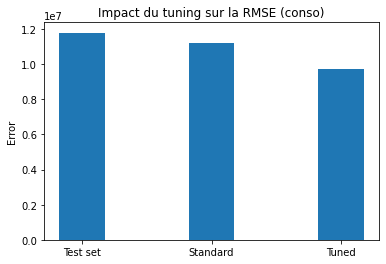

In [74]:
plt.bar(np.arange(3), rmse_conso, 0.35)
plt.ylabel('Error')
plt.title('Impact du tuning sur la RMSE (conso)')
plt.xticks(np.arange(3), ('Test set', 'Standard', 'Tuned'))
plt.show()

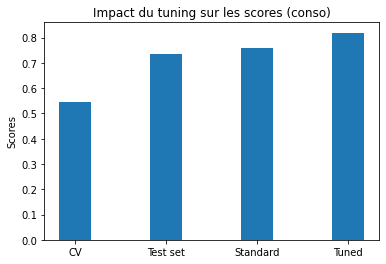

In [75]:
plt.bar(np.arange(4), r2conso, 0.35)
plt.ylabel('Scores')
plt.title('Impact du tuning sur les scores (conso)')
plt.xticks(np.arange(4), ('CV', 'Test set', 'Standard', 'Tuned'))
plt.show()

## CO2 emissions

### StandardScaler on target

In [76]:
standards_pipe_co2 = clone(grids_co2['RandomForestRegressor'])

In [77]:
standards_pipe_co2.transformer = StandardScaler()

In [78]:
print('Start: ', time.asctime())
log_co2 = standards_pipe_co2.fit(X_train_last, y_train_co2)
print('End: ', time.asctime())

Start:  Fri Dec 24 17:24:35 2021
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
End:  Fri Dec 24 17:25:05 2021


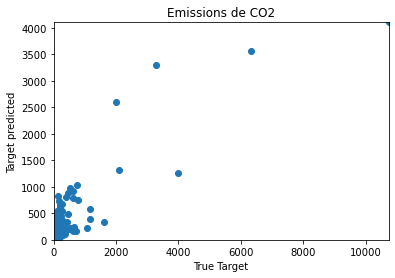


MSE (Mean Squared Error)=215931.938
RMSE (Root Mean Squared Error)=464.685

R2 Test set=0.65
RSE (Relative Squared Error)=0.35

Pearson=0.873, pvalue=0.000


In [79]:
rmse_co2, r2co2 = final(standards_pipe_co2, X_test_last, y_test_co2,
                        'RandomForestRegressor', "Emissions de CO2", rmse_co2, r2co2)

### Hyperparameters

In [80]:
standards_pipe_co2.regressor_.best_params_

{'model__max_depth': 100,
 'model__max_features': 'auto',
 'model__min_samples_split': 25,
 'model__n_estimators': 100,
 'preprocessor__num__scaler': QuantileTransformer(),
 'preprocessor__num__scaler__n_quantiles': 1000}

In [88]:
standards_pipe_co2.regressor.param_grid = {
    'model__max_depth': arange(50, 100, 10),
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__min_samples_split': arange(2, 5, 1),
    'model__n_estimators': arange(95, 105, 1),
    'preprocessor__num__scaler': [QuantileTransformer()],
    'preprocessor__num__scaler__n_quantiles': [1000]}

In [89]:
print('Start: ', time.asctime())
fit = standards_pipe_co2.fit(X_train_last, y_train_co2)
print('End: ', time.asctime())

Start:  Fri Dec 24 17:28:54 2021
Fitting 5 folds for each of 450 candidates, totalling 2250 fits
End:  Fri Dec 24 17:30:33 2021


In [90]:
standards_pipe_co2.regressor_.best_params_

{'model__max_depth': 80,
 'model__max_features': 'auto',
 'model__min_samples_split': 2,
 'model__n_estimators': 100,
 'preprocessor__num__scaler': QuantileTransformer(),
 'preprocessor__num__scaler__n_quantiles': 1000}

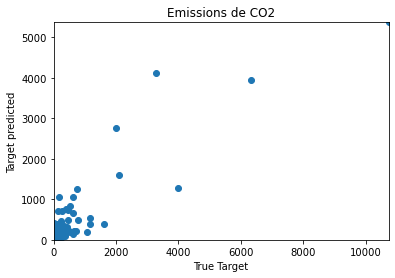


MSE (Mean Squared Error)=163143.535
RMSE (Root Mean Squared Error)=403.910

R2 Test set=0.73
RSE (Relative Squared Error)=0.27

Pearson=0.897, pvalue=0.000


In [91]:
rmse_co2, r2co2 = final(standards_pipe_co2, X_test_last, y_test_co2,
                        'RandomForestRegressor', 'Emissions de CO2', rmse_co2, r2co2)

### Results

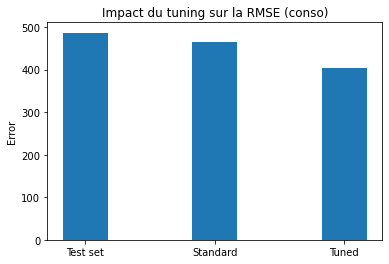

In [96]:
plt.bar(np.arange(3), rmse_co2, 0.35)
plt.ylabel('Error')
plt.title('Impact du tuning sur la RMSE (conso)')
plt.xticks(np.arange(3), ('Test set', 'Standard', 'Tuned'))
plt.show()

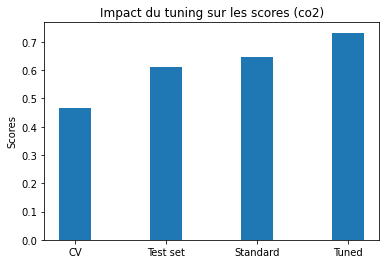

In [97]:
plt.bar(np.arange(4), r2co2, 0.35)
plt.ylabel('Scores')
plt.title('Impact du tuning sur les scores (co2)')
plt.xticks(np.arange(4), ('CV', 'Test set', 'Standard', 'Tuned'))
plt.show()

# ENERGYSTARScore

In [98]:
X_train_perm = X_train.loc[:, (X_train.columns != 'SiteEnergyUse(kBtu)')]
print('X_train_perm: ' + str(X_train_perm.shape))

X_train_perm: (1258, 18)


In [99]:
X_train_perm = X_train_perm[X_train_perm['ENERGYSTARScore'].notna()]
print('X_train_perm: ' + str(X_train_perm.shape))

X_train_perm: (797, 18)


In [100]:
y_train_perm = X_train_perm['TotalGHGEmissions']
print('y_train_perm: ' + str(y_train_perm.shape))

y_train_perm: (797,)


In [101]:
X_train_perm = X_train_perm.drop('TotalGHGEmissions', axis=1)
print('X_train_perm: ' + str(X_train_perm.shape))

X_train_perm: (797, 17)


In [103]:
def permutation(model, X, y):
    r = permutation_importance(model, X, y, n_repeats=100, random_state=0)

    conso_permutation = {'column': [], 'value': []}

    for i in r.importances_mean.argsort()[::-1]:
        conso_permutation['column'].append(X_train_perm.columns[i])
        conso_permutation['value'].append(r.importances_mean[i])
        if X_train_perm.columns[i] == 'ENERGYSTARScore':
            print(X_train_perm.columns[i] + ' %.3f' % (r.importances_mean[i]))

    df_conso_permutation = pd.DataFrame.from_dict(conso_permutation)
    df_conso_permutation.sort_values(by=['value'])

    x = df_conso_permutation['column']
    energy = df_conso_permutation['value']

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, energy, color='steelblue')
    plt.xlabel("Features")
    plt.ylabel("Score")
    plt.title("Permutation score by feature")

    plt.xticks(x_pos, x, rotation=90)

    plt.show()

In [104]:
fit = standards_pipe_co2.fit(X_train_perm, y_train_perm)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


ENERGYSTARScore 0.032


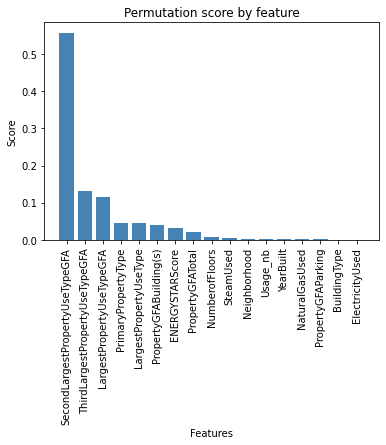

In [105]:
permutation(standards_pipe_co2, X_train_perm, y_train_perm)

# Cache management

In [107]:
# Delete files / folders created for cache
rmtree(location)